# Handling Missing Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import sklearn
import statsmodels as sm

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
''')


pandas -> 1.4.4
numpy -> 1.22.3
matplotlob -> 3.6.1
statsmodels -> 0.13.2
scikit-learn -> 1.1.3



Create necessary functions

In [33]:
## read_datasets

def read_dataset(folder, file, date_col=None):
    '''
    folder: is a path object
    file: the csv filename
    date_col: specify a date_col to use for index_col

    returns: a pandas Dataframe with a DatetimeIndex
    '''
    df = pd.read_csv(folder + file, index_col = date_col, parse_dates=[date_col])
    return df

## plot_dfs

def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

## rmse_score

def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores


### Perform Data Quality checks

In [7]:
co2 = r'./CodeAndDatasets/datasets/Ch7/co2_missing.csv'
ecom = r'./CodeAndDatasets/datasets/Ch7/clicks_missing_multiple.csv'
co2_df = pd.read_csv(co2)
ecom_df = pd.read_csv(ecom, parse_dates=['date'])

print(co2_df.shape)
print(ecom_df.shape)

print(ecom_df.head())

co2_df.head()

(226, 2)
(135, 4)
        date      price  location clicks
0 2008-04-01  43.155647       2.0  18784
1 2008-04-02  43.079056       1.0  24738
2        NaT  43.842609       NaN  15209
3        NaT        NaN       1.0  14018
4        NaT  43.941176       1.0  11974


,year,co2
0,1750,0.0125
1,1760,0.0128
2,1770,0.0150
3,1780,0.0169
4,1790,0.0206


In [13]:
print(co2_df.isnull().sum())

print(co2_df.isna().sum())

print(ecom_df.isnull().sum())

year     0
co2     25
dtype: int64
year     0
co2     25
dtype: int64
date         4
price        1
location     1
clicks      14
dtype: int64


In [14]:
## inspecting file

co2_df[190:195] # pandas by default loads NaN for NA, N/A, null values when used pd.read_csv()
                 # this ehaviour can be modified through na_values parameter

,year,co2
190,1985,NaN
191,1986,NaN
192,1987,NaN
193,1988,4.2953
194,1989,4.2782


In [16]:
## pd.info() provides better understanding
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [17]:
## to get summary statistics for a Dataframe
co2_df.describe(include='all', datetime_is_numeric=True)
   ## summary statistics show min = 0 which means we have missing values in the dataset

,year,co2
count,226.000000,201.000000
mean,1906.902655,1.590015
std,66.543281,1.644182
min,1750.000000,0.000000
25%,1851.250000,0.076400
50%,1907.500000,0.935100
75%,1963.750000,2.807600
max,2020.000000,4.907900


In [18]:
ecom_df.describe(include='all', 
                 datetime_is_numeric=True)
    # '?' value under click column -> pandas doesnt parse this column as numeric

,date,price,location,clicks
count,131,134.000000,134.000000,121
unique,NaN,NaN,NaN,119
top,NaN,NaN,NaN,?
freq,NaN,NaN,NaN,2
mean,2008-06-08 22:32:03.664122112,43.480221,1.694030,NaN
min,2008-04-01 00:00:00,42.207018,1.000000,NaN
25%,2008-05-07 12:00:00,43.038050,1.000000,NaN
50%,2008-06-09 00:00:00,43.498842,1.000000,NaN
75%,2008-07-11 12:00:00,43.889935,2.000000,NaN
max,2008-08-13 00:00:00,45.801613,5.000000,NaN


In [19]:
## convert 0 and ? values to NaN using dataframe.replace()
co2_df.replace(0, np.NaN, inplace=True)
ecom_df.replace('?', np.NaN, inplace=True)

     # once these values became NaN, the CSV reader could parse the co2
      # column as float64 (numeric) based on the remaining non-null values
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

In [25]:
## Now missing values are 
print(co2_df.isnull().sum())

print(ecom_df.isnull().sum())

## u can change th default beaviour of pandas to NaN values
co2_df2 = pd.read_csv(co2, keep_default_na=False)

print(co2_df2.isnull().sum())
print(co2_df2[190:195]) # not changes all unrecognised values to NaN

pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}).describe() # added '?' to list that willl be converted to NaN


year     0
co2     35
dtype: int64
date         4
price        1
location     1
clicks      16
dtype: int64
year    0
co2     0
dtype: int64
     year     co2
190  1985      NA
191  1986     N/A
192  1987    null
193  1988  4.2953
194  1989  4.2782


,price,location,clicks
count,134.000000,134.000000,119.000000
mean,43.480221,1.694030,9530.336134
std,0.610578,1.118724,4687.587507
min,42.207018,1.000000,2044.000000
25%,43.038050,1.000000,6438.000000
50%,43.498842,1.000000,8391.000000
75%,43.889935,2.000000,11363.500000
max,45.801613,5.000000,29505.000000


## Handling Missing Data with Univariate Imputation using pandas  

Some basic univariate imputation techniques include the following:
* Imputing using the mean.
* Imputing using the last observation forward (forward fill). This can be referred to as Last Observation Carried Forward (LOCF).
* Imputing using the next observation backward (backward fill). This can be referred to as Next Observation Carried Backward (NOCB).

co2    35
dtype: int64
price        0
location     0
clicks      16
dtype: int64
2


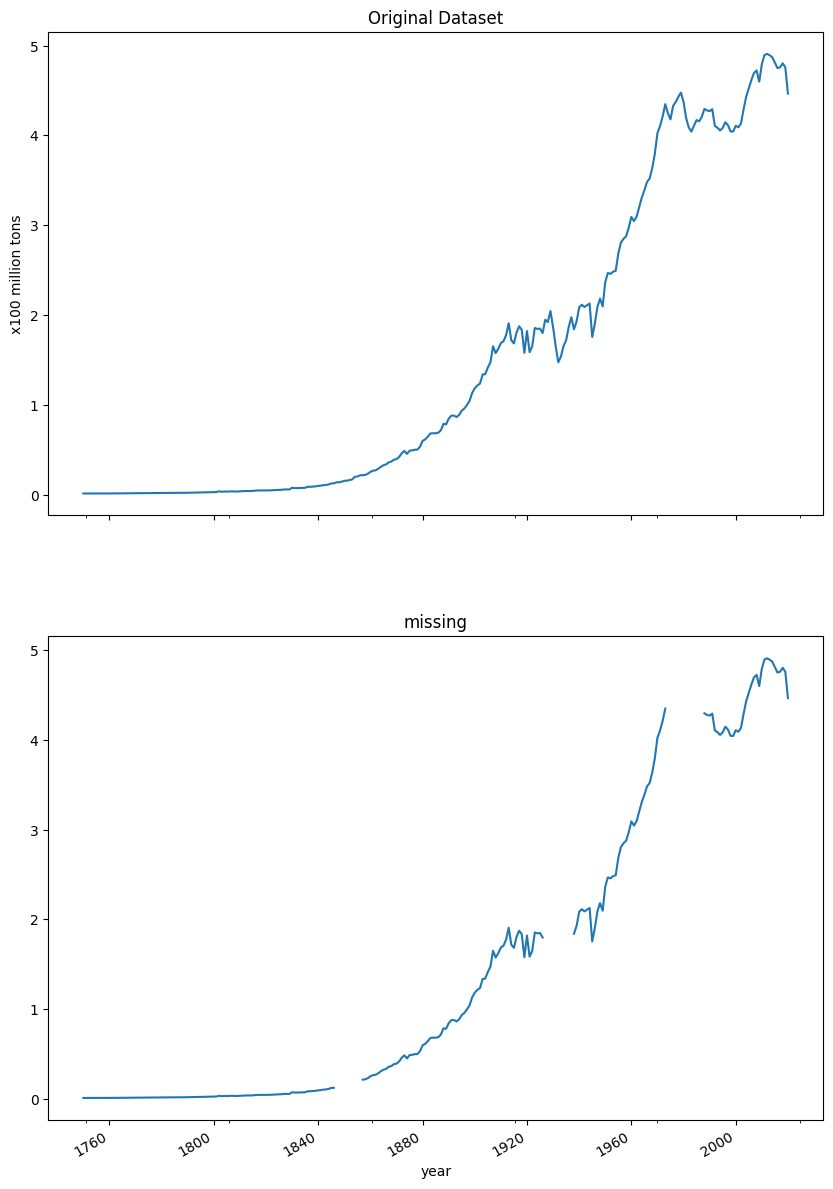

In [35]:

folder = r'./CodeAndDatasets/datasets/Ch7/'

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

print(co2_missing.isnull().sum())
print(clicks_missing.isnull().sum())
print(clicks_missing.loc[:, 'missing':].shape[1])

plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

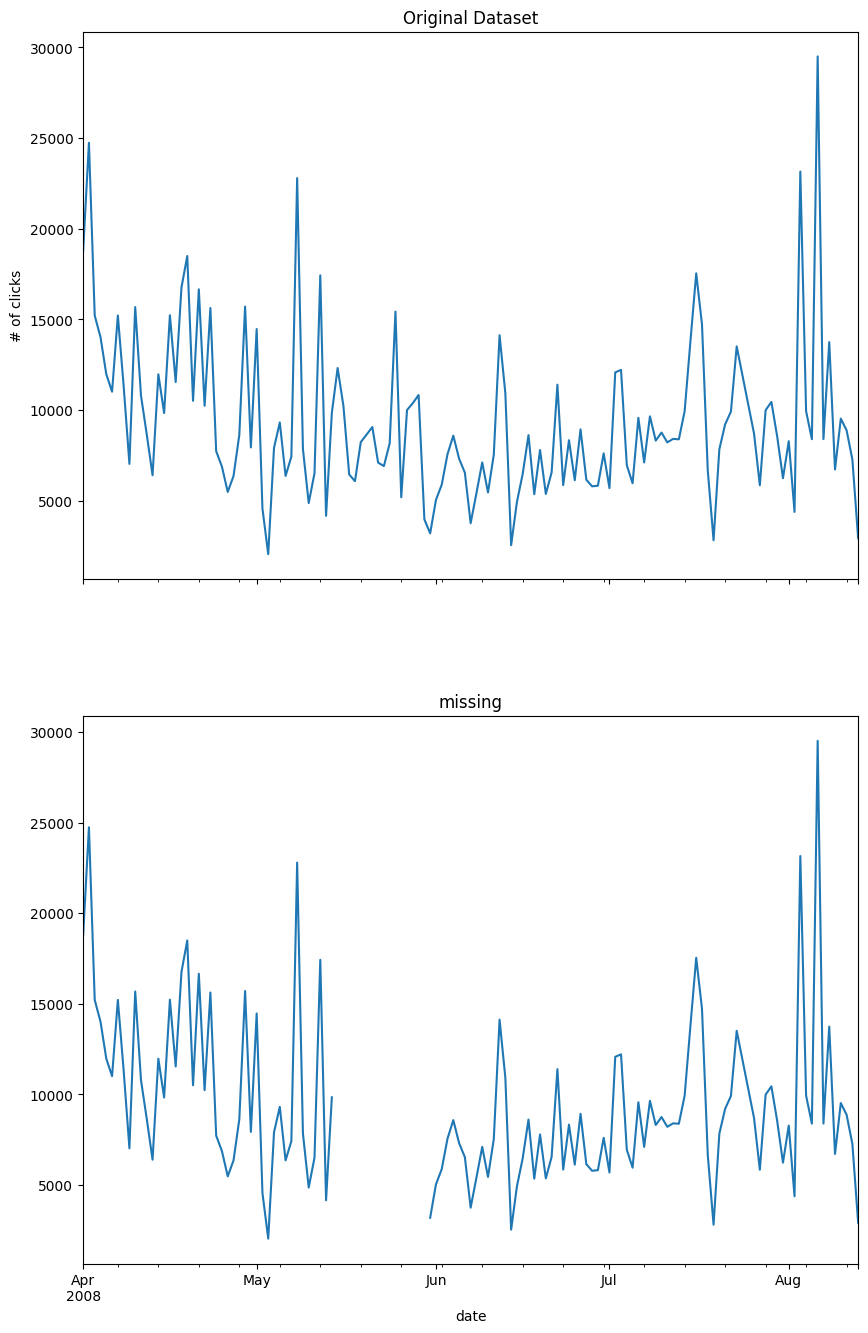

In [36]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684
[0.05873012599267133, 0.05550012995280968, 0.7156383637041684]


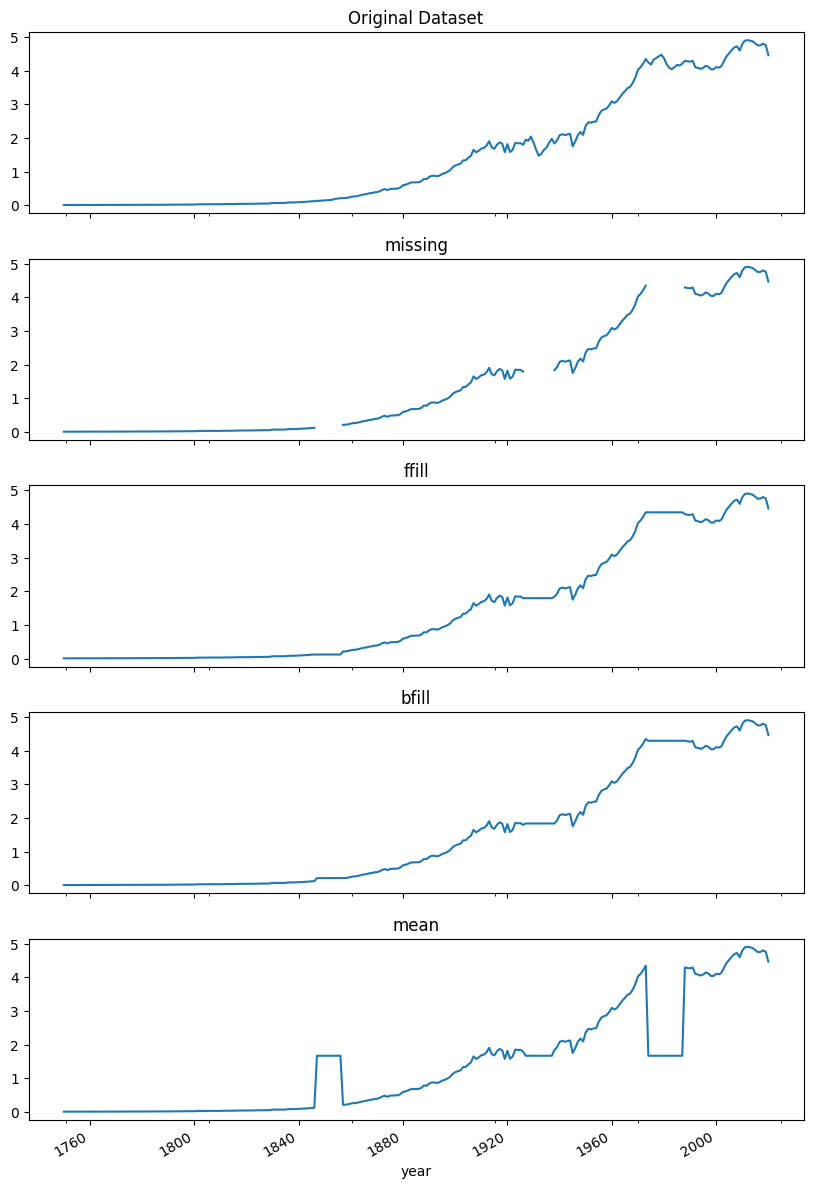

In [37]:
## idenifying best fill using RMSE score
co2_missing['ffill'] = co2_missing['co2'].fillna(method='ffill')
co2_missing['bfill'] = co2_missing['co2'].fillna(method='bfill')
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

cor_rmse_compare = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

print(cor_rmse_compare)

plot_dfs(co2_original, co2_missing, 'co2')

RMSE for ffil: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953
[1034.1210689204554, 2116.6840489225033, 997.7600138929953]


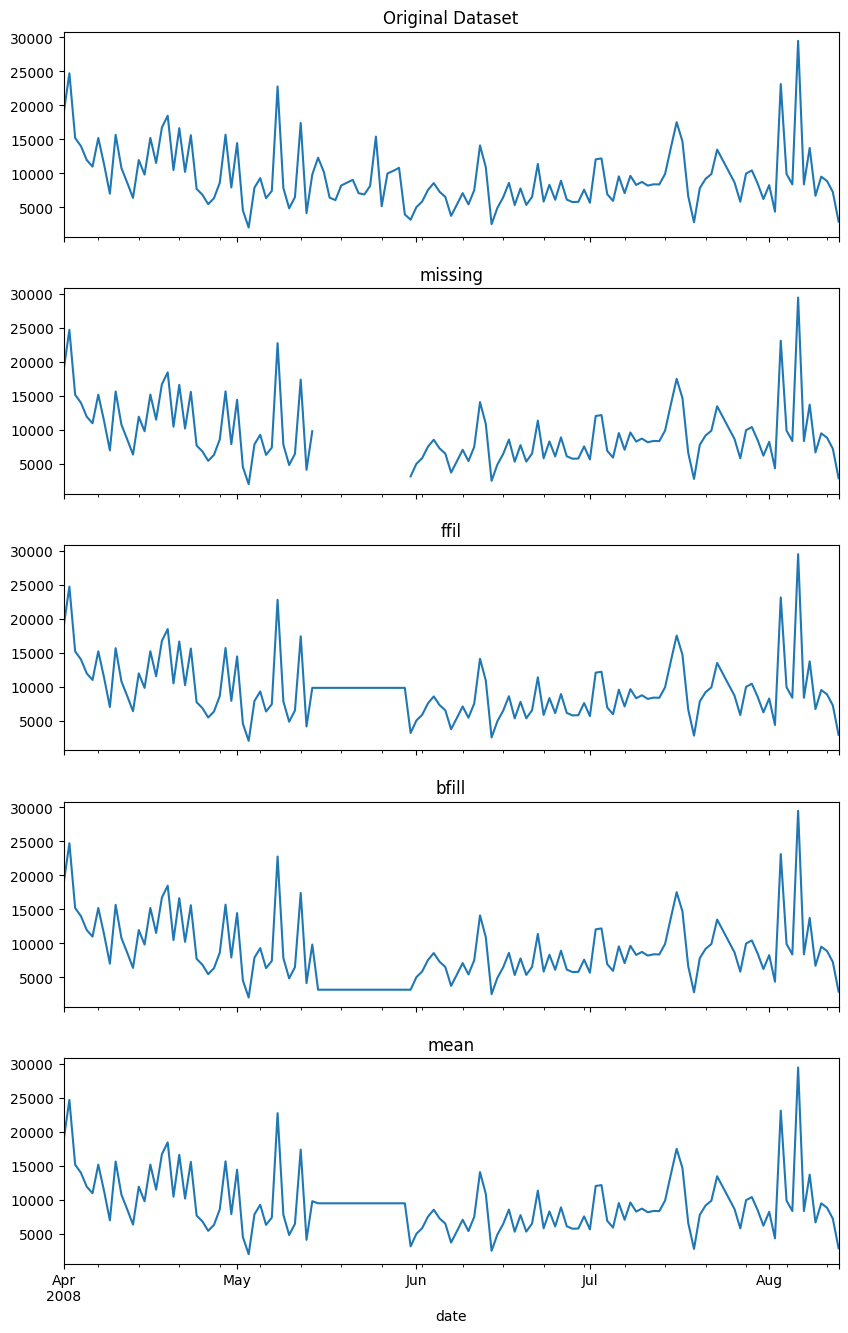

In [38]:
clicks_missing['ffil'] = clicks_missing['clicks'].fillna(method='ffill')
clicks_missing['bfill'] = clicks_missing['clicks'].fillna(method='bfill')
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

rmse_clicks_missing = rmse_score(clicks_original, 
                    clicks_missing, 
                    'clicks')

print(rmse_clicks_missing)

plot_dfs(clicks_original, clicks_missing, 'clicks')

### Handling Missing Data with Univariate Imputation using Scikit-Learn

In [39]:
from sklearn.impute import SimpleImputer

strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]


co2_vals = co2_missing['co2'].values.reshape(-1,1)
clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)

for s_name, s in strategy:
    co2_missing[s_name] = (
        SimpleImputer(strategy=s).fit_transform(co2_vals))
    clicks_missing[s_name] = (
        SimpleImputer(strategy=s).fit_transform(clicks_vals))

rmse_sklearn_co2 = rmse_score(co2_original, co2_missing, 'co2')
print(rmse_sklearn_co2)

rmse_sklearn_clicks = rmse_score(clicks_original, clicks_missing, 'clicks')
print(rmse_sklearn_clicks)

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684
RMSE for Mean Strategy: 0.7156383637041684
RMSE for Median Strategy: 0.8029421606859859
RMSE for Most Frequent Strategy: 1.1245663822743381
[0.05873012599267133, 0.05550012995280968, 0.7156383637041684, 0.7156383637041684, 0.8029421606859859, 1.1245663822743381]
RMSE for ffil: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953
RMSE for Mean Strategy: 997.7600138929953
RMSE for Median Strategy: 959.3580492530756
RMSE for Most Frequent Strategy: 1097.6425985146868
[1034.1210689204554, 2116.6840489225033, 997.7600138929953, 997.7600138929953, 959.3580492530756, 1097.6425985146868]


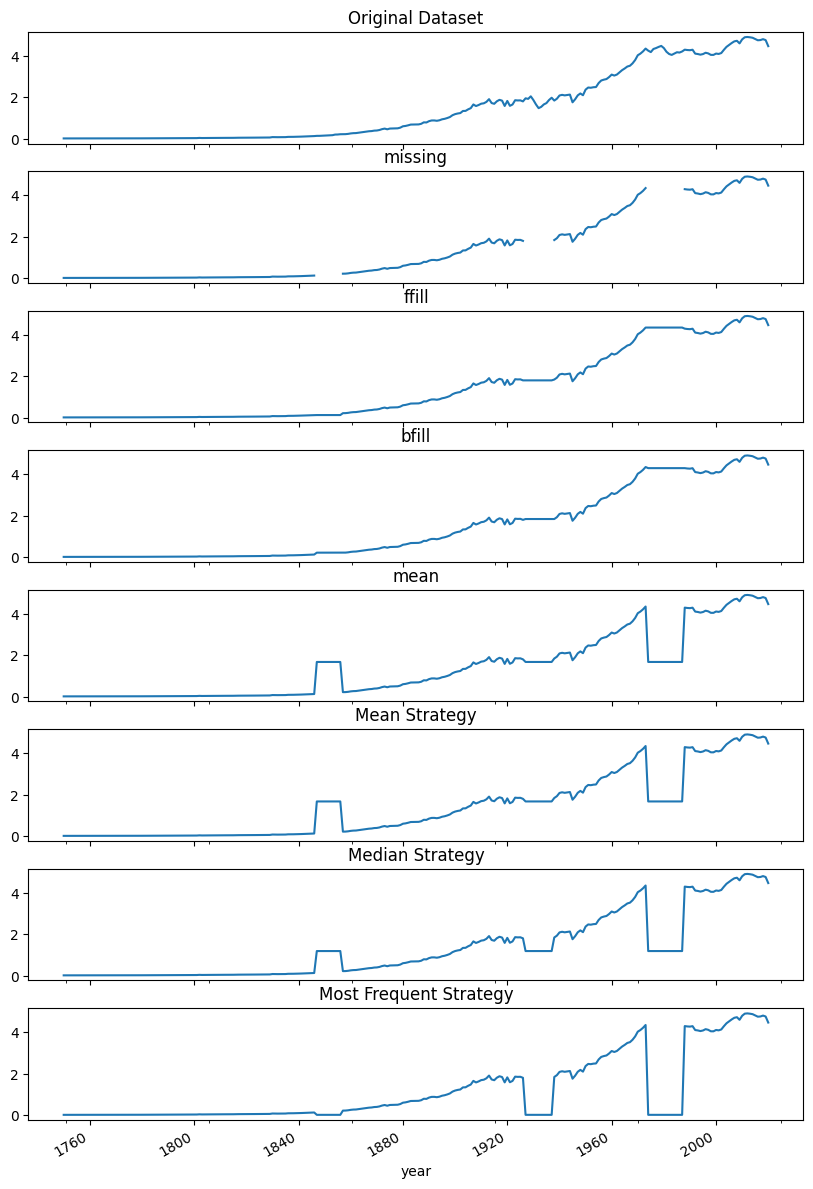

In [40]:
plot_dfs(co2_original, co2_missing, 'co2')

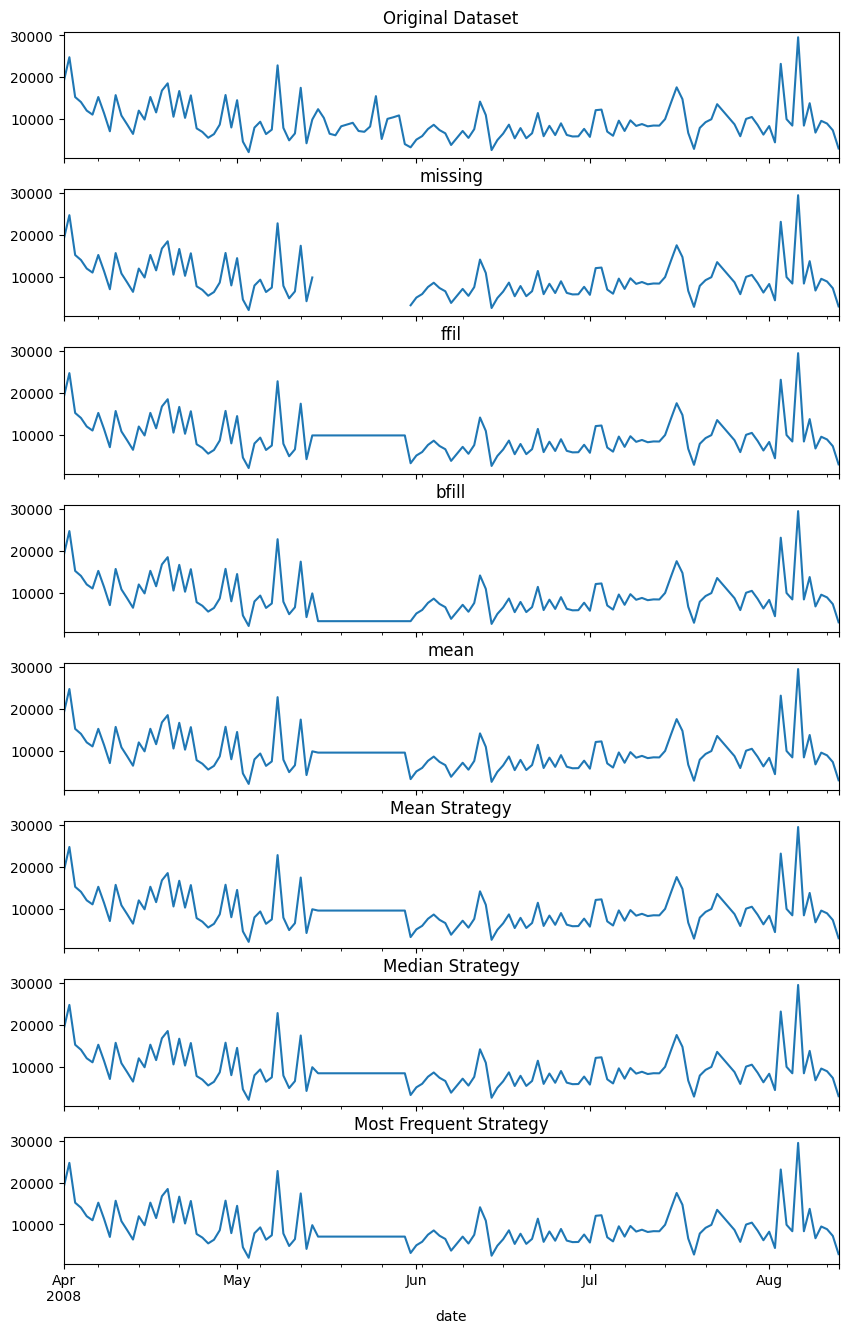

In [41]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

### Handling Missing Data with Multivariate Imputation

c:\Users\kbhas\anaconda3\envs\ML_for_CV_env\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\kbhas\anaconda3\envs\ML_for_CV_env\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\kbhas\anaconda3\envs\ML_for_CV_env\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


RMSE for bayesianRidge: 1188.0651966148187
RMSE for extra_tress: 1509.5581080175357
RMSE for bagging: 1351.2974601936933
RMSE for elastic_net: 945.4075209343099
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822
[1188.0651966148187, 1509.5581080175357, 1351.2974601936933, 945.4075209343099, 938.9419831427186, 1336.8798392251822]


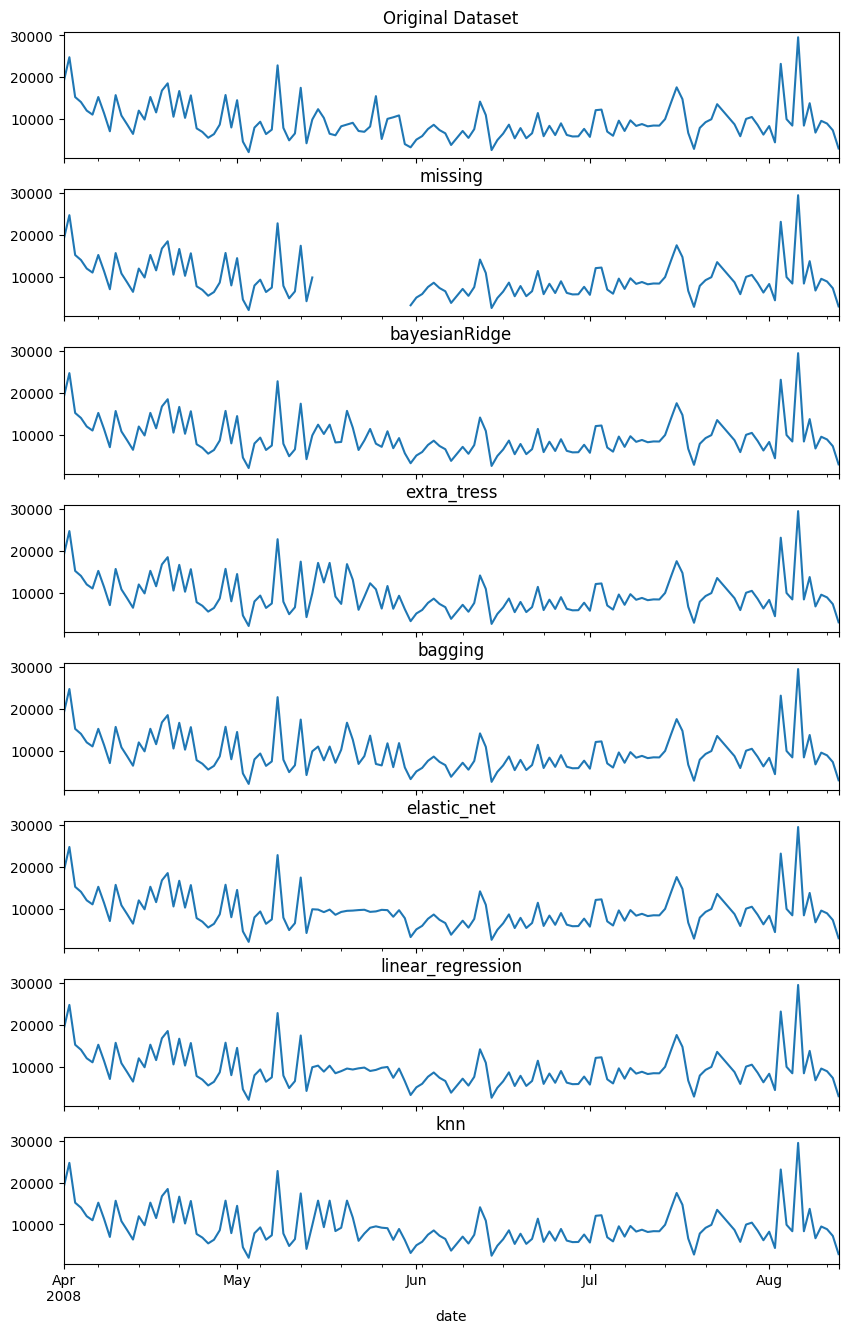

In [45]:
## multivariate Imputation using sklearn

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor


folder = r'./CodeAndDatasets//datasets/Ch7/'

clicks_original = read_dataset(folder, 
                            'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                            'clicks_missing.csv', 'date')


estimators = [
    ('bayesianRidge', BaggingRegressor()),
    ('extra_tress', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]


clicks_vals = clicks_missing.iloc[:,0:3].values

for e_name, e in estimators:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_vals)
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]

multivar_clicks_rmse = rmse_score(clicks_original, clicks_missing, 'clicks')
print(multivar_clicks_rmse)

plot_dfs(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 1188.0651966148187
RMSE for extra_tress: 1509.5581080175357
RMSE for bagging: 1351.2974601936933
RMSE for elastic_net: 945.4075209343099
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822
RMSE for MICE: 2122.957397384863
[1188.0651966148187, 1509.5581080175357, 1351.2974601936933, 945.4075209343099, 938.9419831427186, 1336.8798392251822, 2122.957397384863]


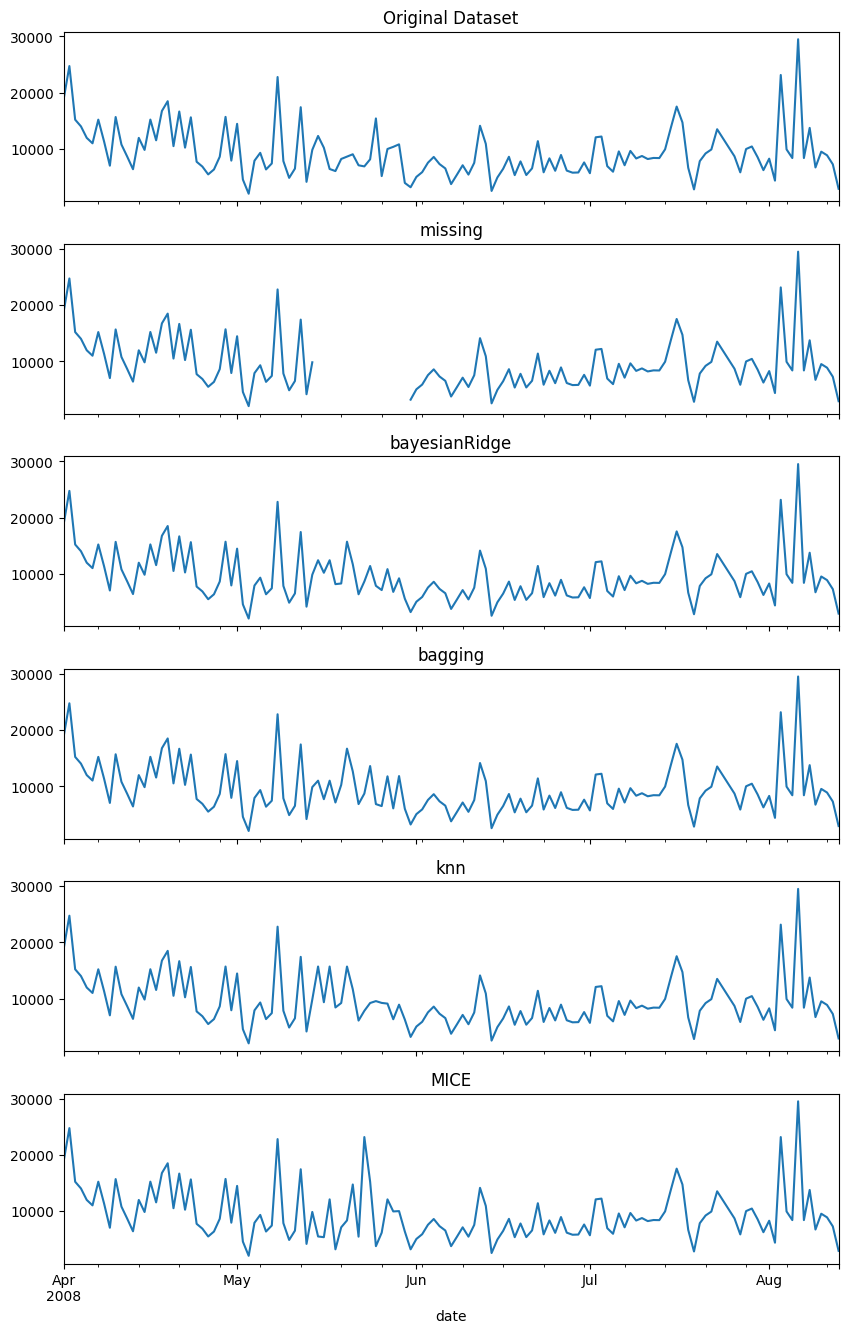

In [47]:
## multivariate Imputation using statsmodels

from statsmodels.imputation.mice import MICE, MICEData, MICEResults
import statsmodels.api as sm

# create a MICEData object
fltr = ['price', 'location','clicks']
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
# 20 iterations
mice_data.update_all(n_iter=20)

mice_data.set_imputer('clicks', formula='~ price + location', model_class=sm.OLS)

clicks_missing['MICE']  = mice_data.data['clicks'].values.tolist()

stats_rmse_clicks = rmse_score(clicks_original, clicks_missing, 'clicks')

print(stats_rmse_clicks)

cols = ['clicks','bayesianRidge', 'bagging', 'knn', 'MICE']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')


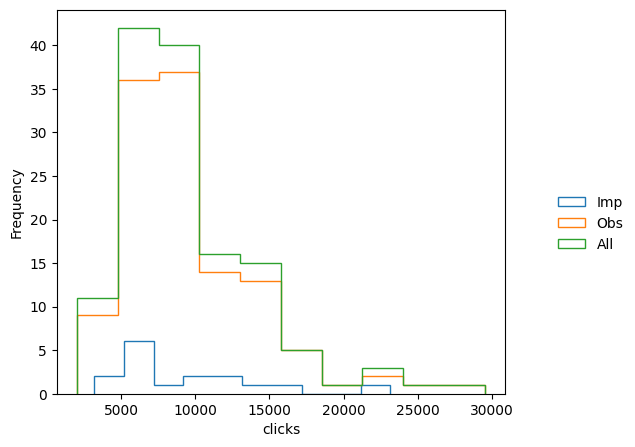

In [48]:
imputed_hist = mice_data.plot_imputed_hist('clicks')

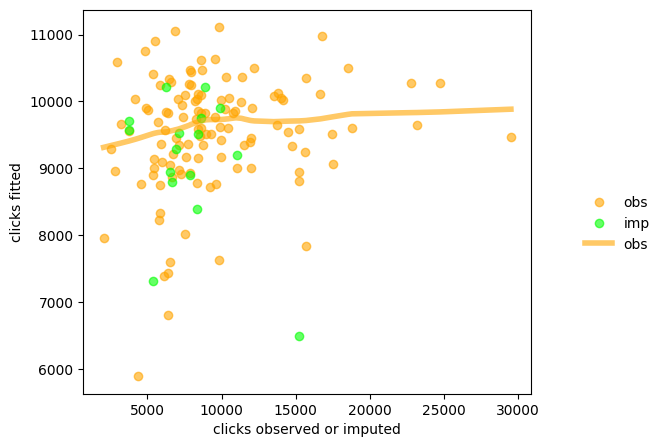

In [49]:
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
mice_data.update_all(n_iter=20)
_ = mice_data.plot_fit_obs('clicks')

### Handling Missing Data with Interpolation

Linear interpolation can be used to impute missing data by drawing a straight line between the two points surrounding the missing value.

A polynomial interpolation will attempt to draw a curved line between the two points

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614347
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833133
RMSE for spline: 0.17765043760996155
RMSE for polynomial: 0.08373627305833133
RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626975
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782831
RMSE for spline: 6197.349119678481
RMSE for polynomial: 6199.304875782831
[0.05507291327761665, 0.08367561505614347, 0.05385422309469095, 0.08373627305833133, 0.17765043760996155, 0.08373627305833133]

[1329.1448378562811, 5224.641260626975, 1706.1853705030173, 6199.304875782831, 6197.349119678481, 6199.304875782831]


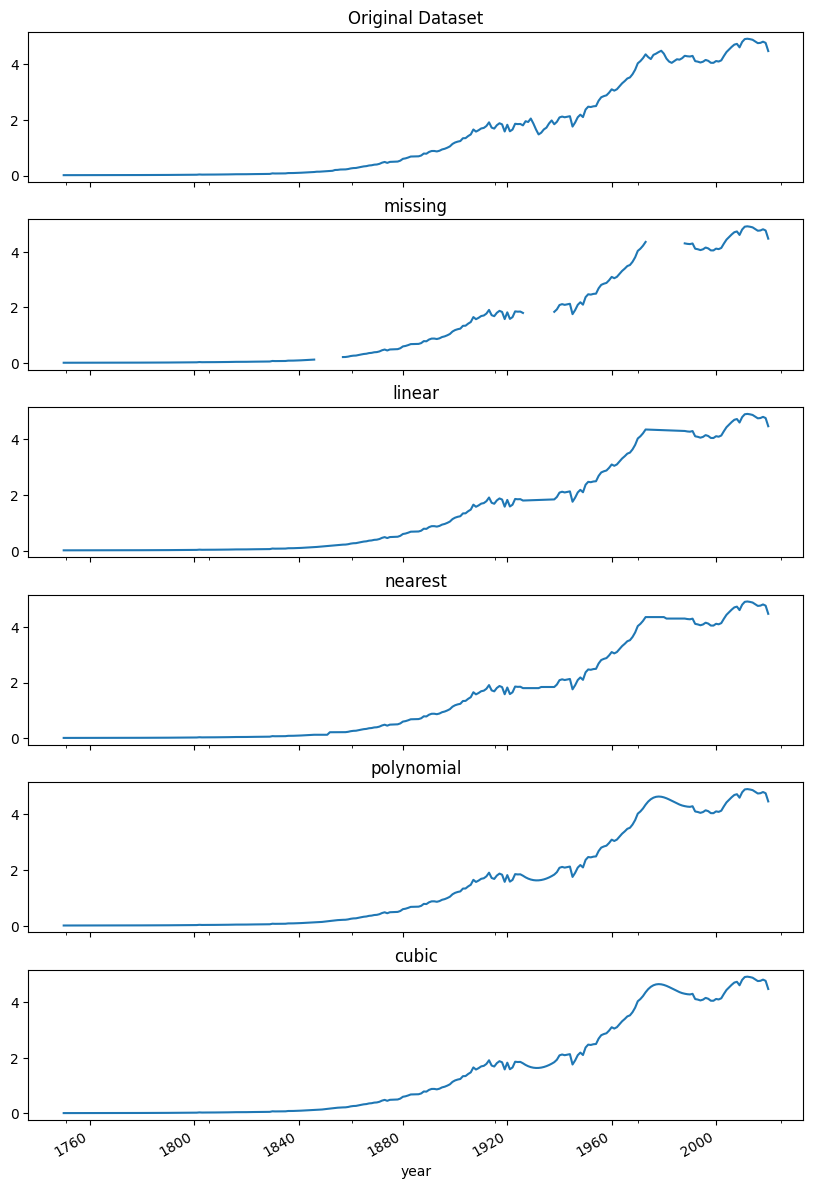

In [51]:
folder = r'./CodeAndDatasets/datasets/Ch7/'

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

## applying multiple interpolation techniques
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)


co2_missing['spline'] = \
        co2_missing['co2'].interpolate(method='spline', order=3)
clicks_missing['spline'] = \
        clicks_missing['clicks'].interpolate(method='spline',order=3)

co2_missing['polynomial'] = \
        co2_missing['co2'].interpolate(method='polynomial',order=3)
clicks_missing['polynomial'] = \
        clicks_missing['clicks'].interpolate(method='polynomial',order=3)

interpolation_rmse_co2 = rmse_score(co2_original, co2_missing, 'co2')
interpolation_rmse_clicks = rmse_score(clicks_original, clicks_missing, 'clicks')

print(interpolation_rmse_co2)
print()
print(interpolation_rmse_clicks)

cols = ['co2', 'linear', 'nearest', 'polynomial', 'cubic']
plot_dfs(co2_original, co2_missing[cols], 'co2')

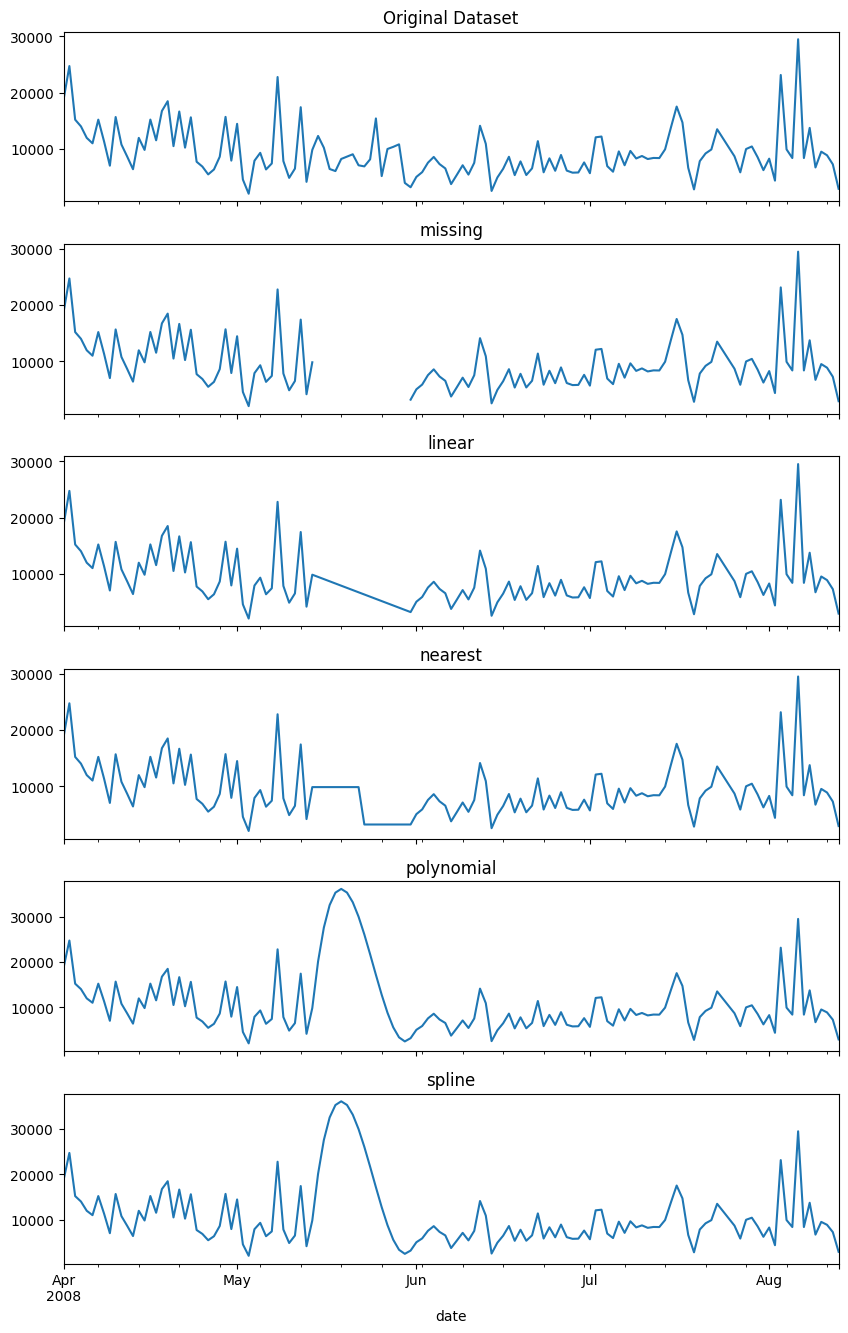

In [52]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

In [53]:
print(clicks_missing['clicks'].isna().sum())

## limit parameter allows to set maximum number of NaN to fill

example = clicks_missing['clicks'].interpolate(limit = 5)

print(example.isna().sum())

16
11


# Outlier Detection using statistical methods

The methods and techniques to identify **outlier**
or **anomaly observations** are similar; the difference lies in the context and the actions 
that follow once these points have been identified.


change point detection (CPD), relates to outlier detection. In 
CPD, the goal is to anticipate abrupt and impactful fluctuations (increasing or decreasing) 
in the time series data. CPD covers specific techniques, for example, **cumulative sum
(CUSUM) and Bayesian online change point detection (BOCPD)**

This distinction between outlier detection and CPD is vital since you sometimes want the latter. Where the two disciplines converge, depending on the context, sudden changes may indicate the potential presence of outliers (anomalies).

The recipes that you will encounter in this chapter are as follows:  
* Resampling time series data
* Detecting outliers using visualizations
* Detecting outliers using the Tukey method
* Detecting outliers using a z-score
* Detecting outliers using a modified z-score

In [55]:
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy 
import statsmodels
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 16, 3


print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.6.1
pandas -> 1.4.4   
scipy -> 1.7.3
statsmodels -> 0.13.2




## Resampling Time series data

In [77]:
## load nyc_taxi data
file = r"./CodeAndDatasets/datasets/Ch8/nyc_taxi.csv"
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)
print(nyc_taxi.head()) ## 30 mins frequency data
print(nyc_taxi.shape)

## downsampling
df_downsampled = nyc_taxi.resample('D').mean()
print(df_downsampled.head())

print(df_downsampled.shape)
## upsampling -> creates NaN rows. 
df_upsampled = nyc_taxi.resample('15T').mean()
print(df_upsampled.head())

print(df_upsampled.shape)

df_upsampled = df_upsampled.fillna(method='ffill')
print(df_upsampled.head())

## You can supply more than one aggregation at once when downsampling using the .agg() function

df_multi_downsample = nyc_taxi.resample('M').agg(['mean', 'min', 'max', 'median', 'sum'])

df_multi_downsample

                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820
(10320, 1)
                   value
timestamp               
2014-07-01  15540.979167
2014-07-02  15284.166667
2014-07-03  14794.625000
2014-07-04  11511.770833
2014-07-05  11572.291667
(215, 1)
                       value
timestamp                   
2014-07-01 00:00:00  10844.0
2014-07-01 00:15:00      NaN
2014-07-01 00:30:00   8127.0
2014-07-01 00:45:00      NaN
2014-07-01 01:00:00   6210.0
(20639, 1)
                       value
timestamp                   
2014-07-01 00:00:00  10844.0
2014-07-01 00:15:00  10844.0
2014-07-01 00:30:00   8127.0
2014-07-01 00:45:00   8127.0
2014-07-01 01:00:00   6210.0


value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889

<AxesSubplot: title={'center': 'NYC Taxi'}, xlabel='timestamp'>

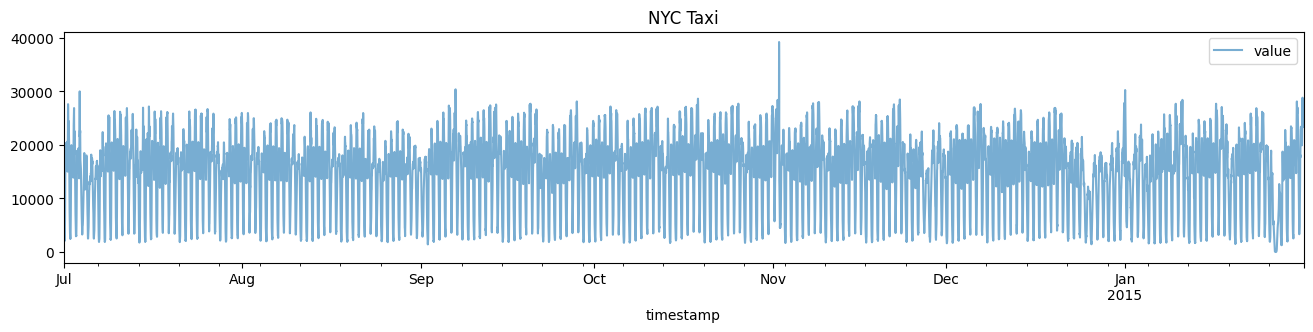

In [59]:
## load nyc_taxi data
file = r"./CodeAndDatasets/datasets/Ch8/nyc_taxi.csv"
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)

## updating index to 30 mins frequency
nyc_taxi.index.freq = '30T'

## plot outliers
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi','outliers'])
    plt.show()

## below dates have some insights into their significance.
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

nyc_taxi.plot(title="NYC Taxi", alpha=0.6)

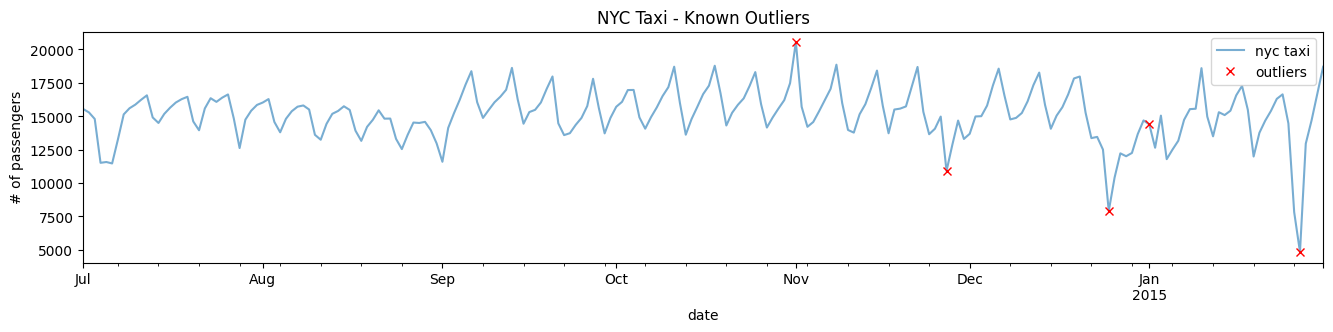

In [60]:
## resample data to day level and average value as mean() is very sensitive to outliers
tx = nyc_taxi.resample('D').mean()

## already known outlier dates found using outlier detection techniiques
known_outliers = tx.loc[nyc_dates]

plot_outliers(known_outliers, tx, 'Known Outliers')

## Detection of Outliers

0.12.0


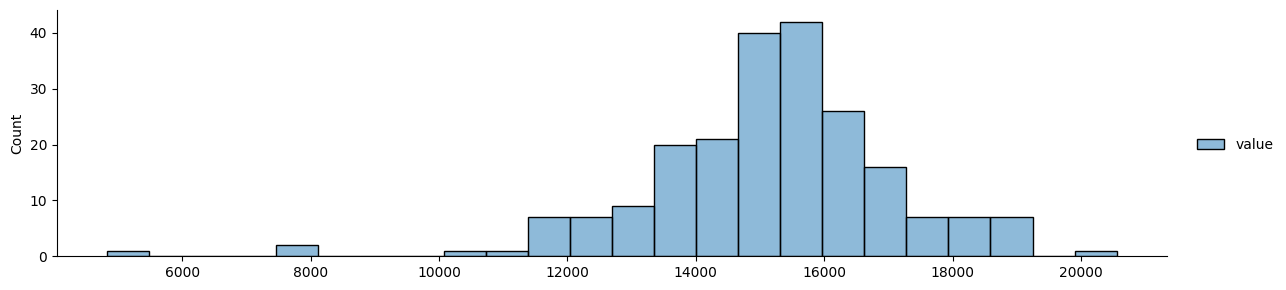

In [84]:
### Detecting Outliers using visualization plots

import seaborn as sns
print(sns.__version__)

## Histogram
sns.displot(tx, kind='hist', height=3, aspect=4)

<AxesSubplot: >

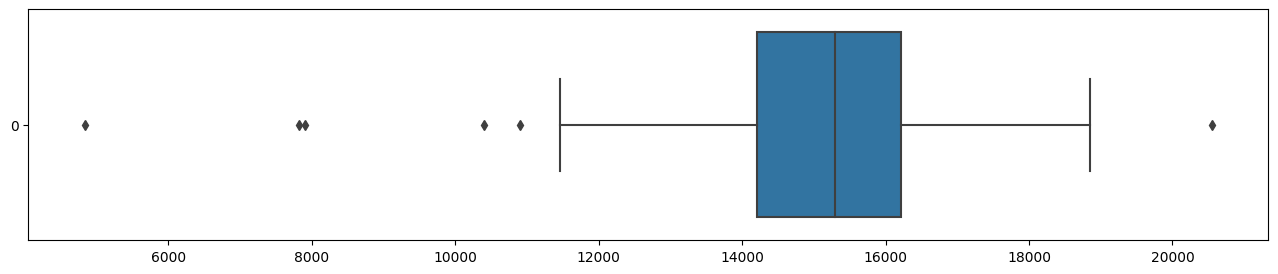

In [86]:
## Box plot is better than histogram for spotting outliers

sns.boxplot(tx['value'], whis=1.5, orient='h')

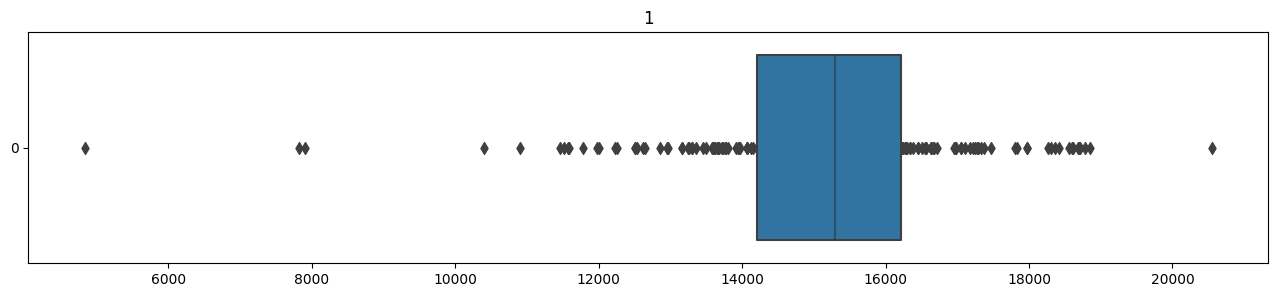

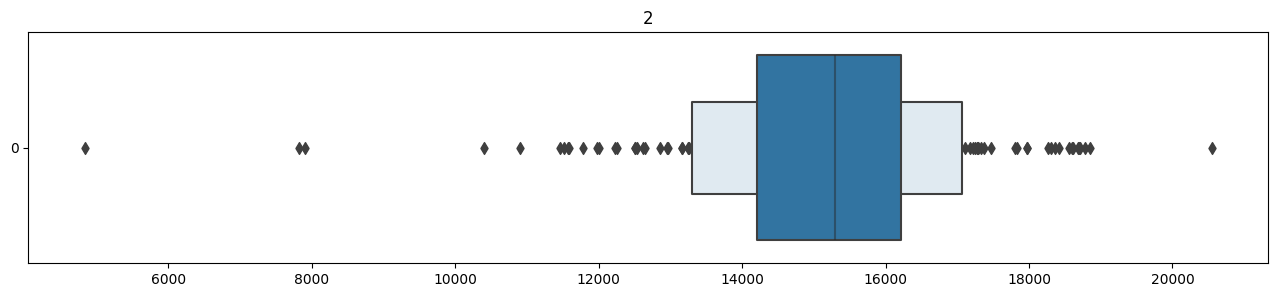

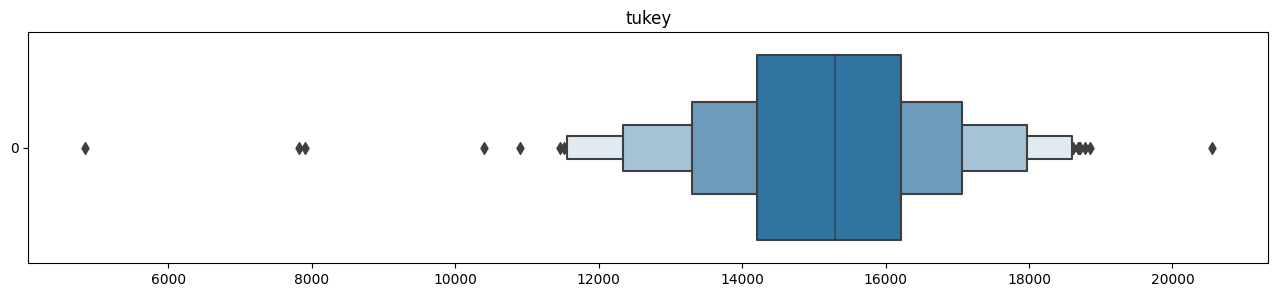

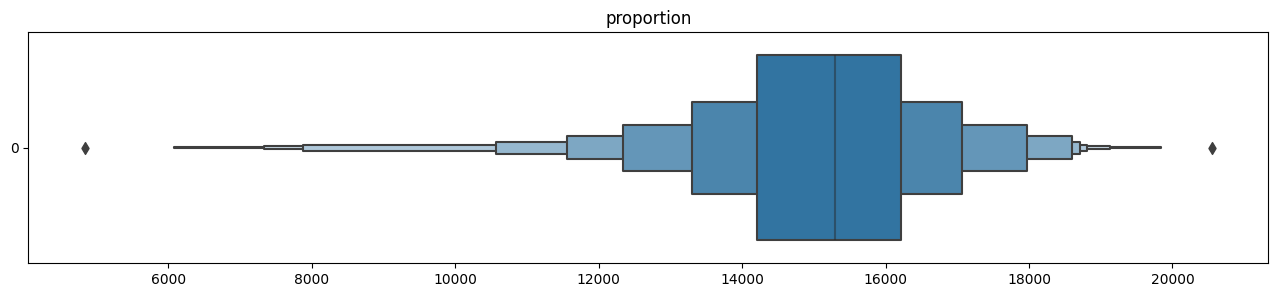

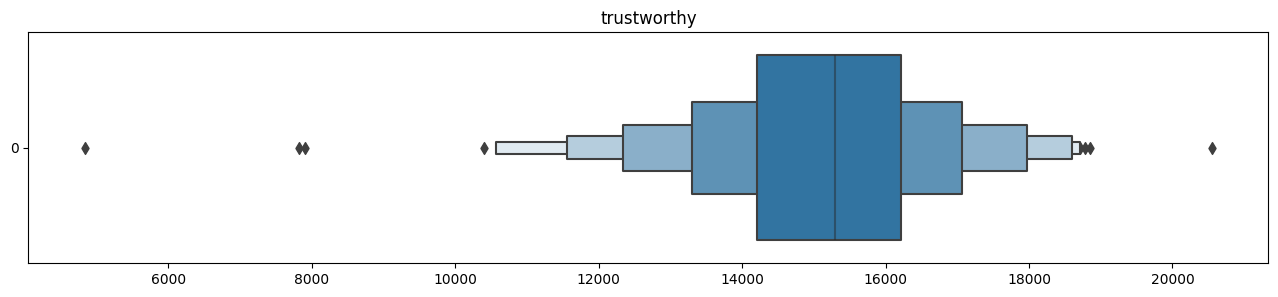

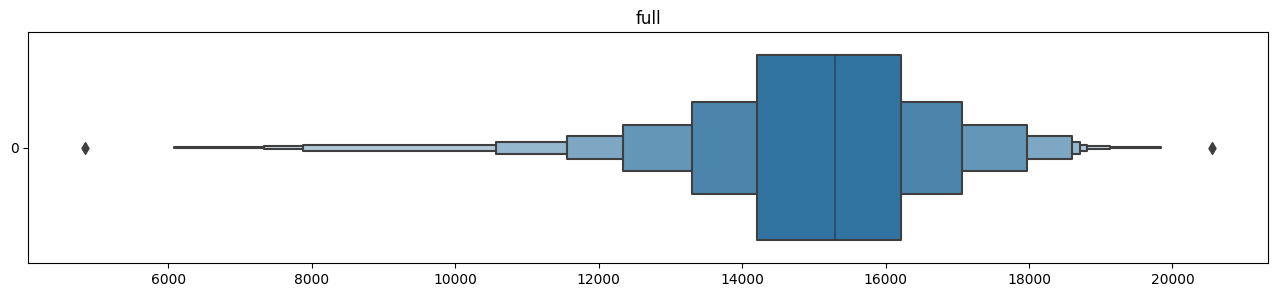

In [91]:
## Boxen plot (Letter-value plot) is similaar to box plot ans are good for large datasets

# sns.boxenplot(tx['value'], orient='h')
# exploring different methods
for k in [1, 2, "tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(tx['value'], k_depth=k, orient='h')
    plt.title(k)
    plt.show()

<AxesSubplot: >

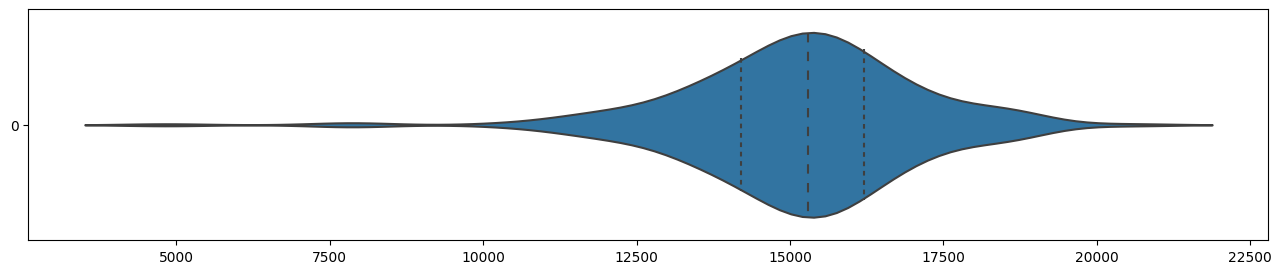

In [93]:
## violin plot

sns.violinplot(tx['value'], inner='quartile', orient='h')


<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

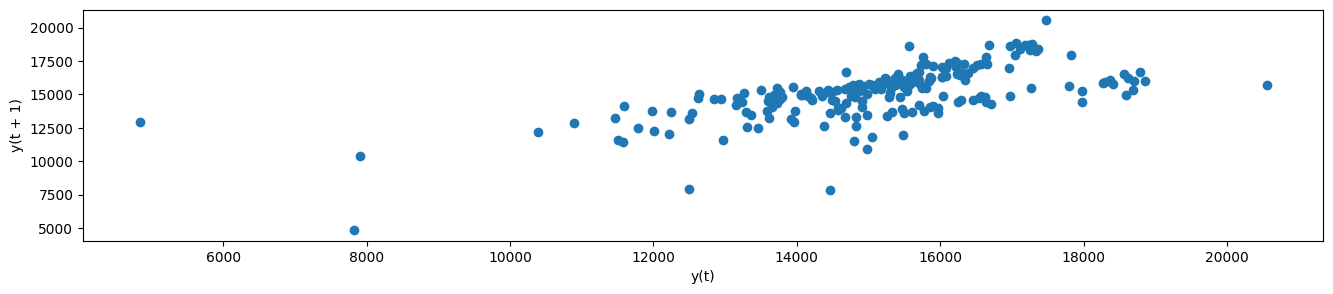

In [94]:
## lag plot

from pandas.plotting import lag_plot

lag_plot(tx)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


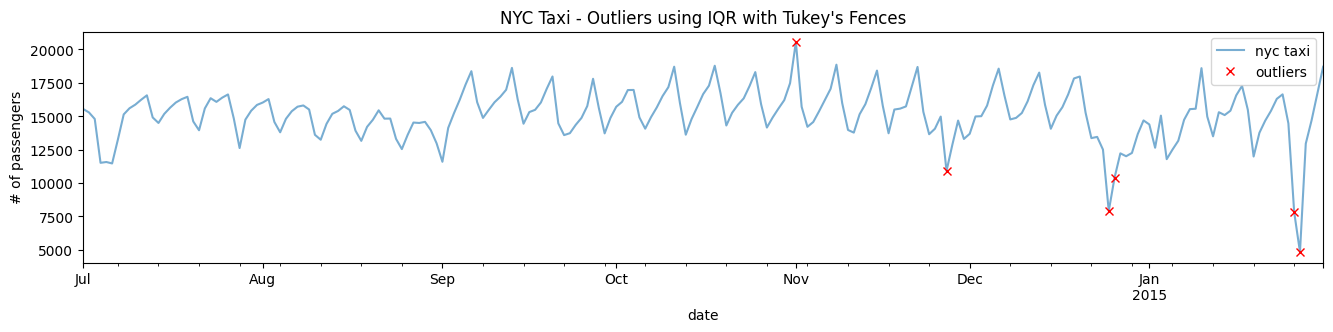

In [96]:
### Outlier detection using Tukey method. whisker size is  1.5 times of IQR

percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles= percentiles)

## numpy offers percentile funciton which returns the values of specfied percentiles

percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

outliers = iqr_outliers(tx)
print(outliers)

plot_outliers(outliers, tx, "Outliers using IQR with Tukey's Fences")

array([[<AxesSubplot: title={'center': 'value'}>,
        <AxesSubplot: title={'center': 'zscore'}>]], dtype=object)

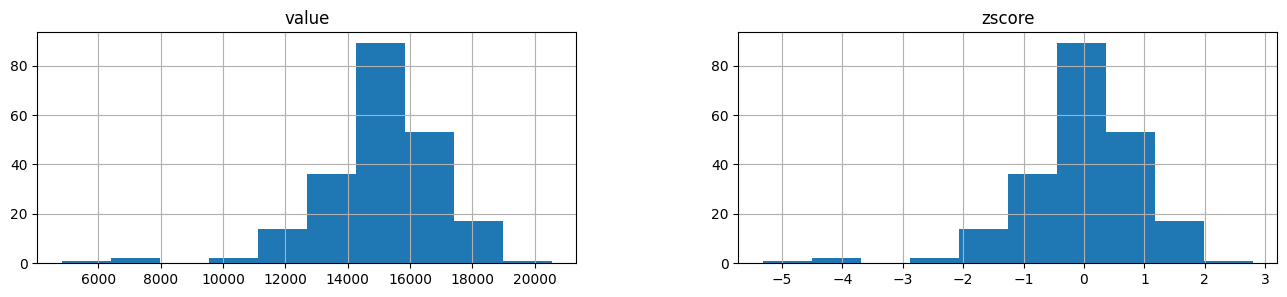

In [97]:
### Detection of outlies using z-score
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    
    return outliers['value'], data

threshold = 2.5 # we have to play around 
outliers, transformed = zscore(tx, threshold)

transformed.hist()

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667
timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


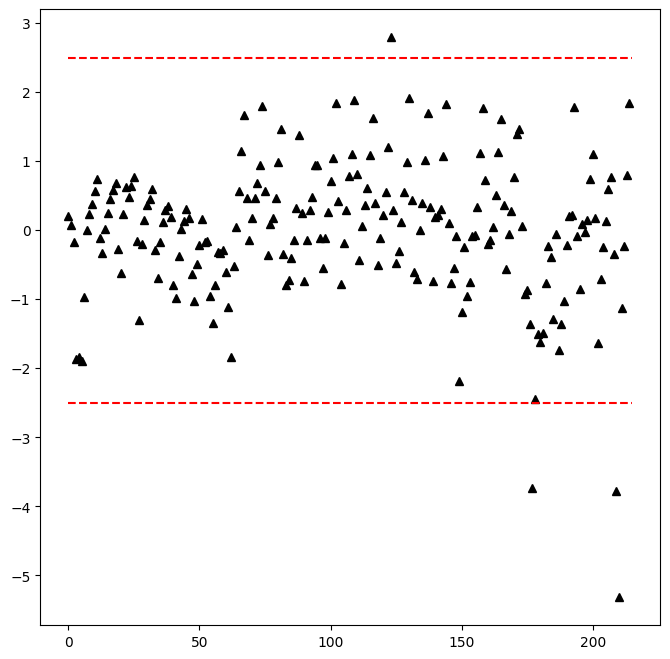

In [98]:
print(known_outliers)
print(outliers)

def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')


data = transformed['zscore'].values
plot_zscore(data, d=2.5) # 2.5 means data point is 2.5 std away from mean.

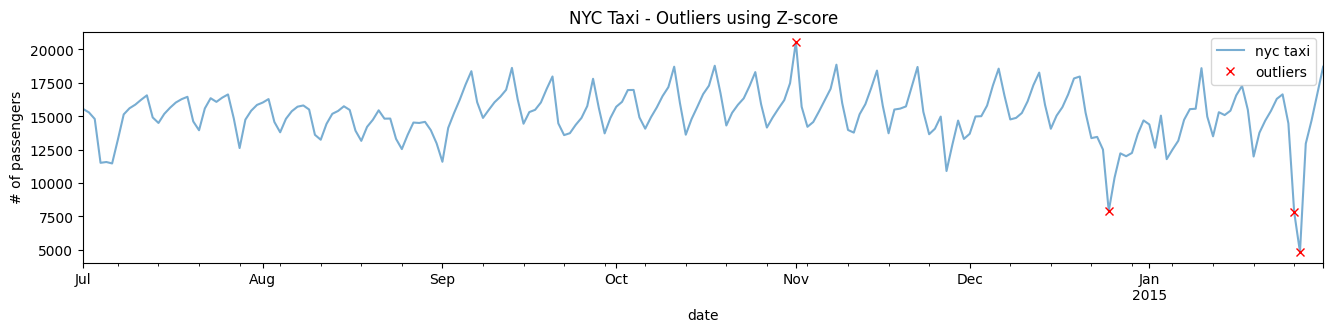

In [99]:
plot_outliers(outliers, tx, 'Outliers using Z-score')

In [100]:

from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")
test_normal(tx)


Reject null hypothesis. Data is not normal


0.6744897501960817
(6,)


array([[<AxesSubplot: title={'center': 'value'}>,
        <AxesSubplot: title={'center': 'm_zscore'}>]], dtype=object)

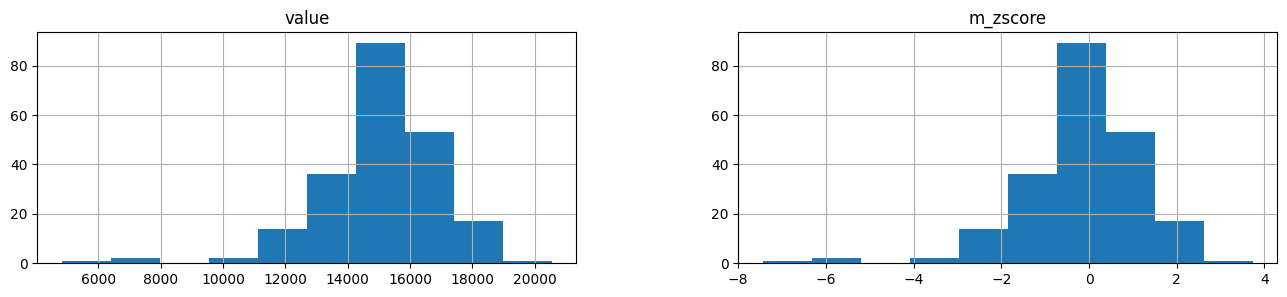

In [101]:
## If data is not normal , we have to use Modified z-score
# ppf -> percent point function (Inverse of Cummulative distribution function)

import scipy.stats as stats
print(stats.norm.ppf(0.75))

def modified_zscore(df, degree=3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data - data.median())
    MAD = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]
    
    return outliers['value'], data

threshold =  3
outliers, transformed = modified_zscore(tx, threshold)

print(outliers.shape)

transformed.hist()

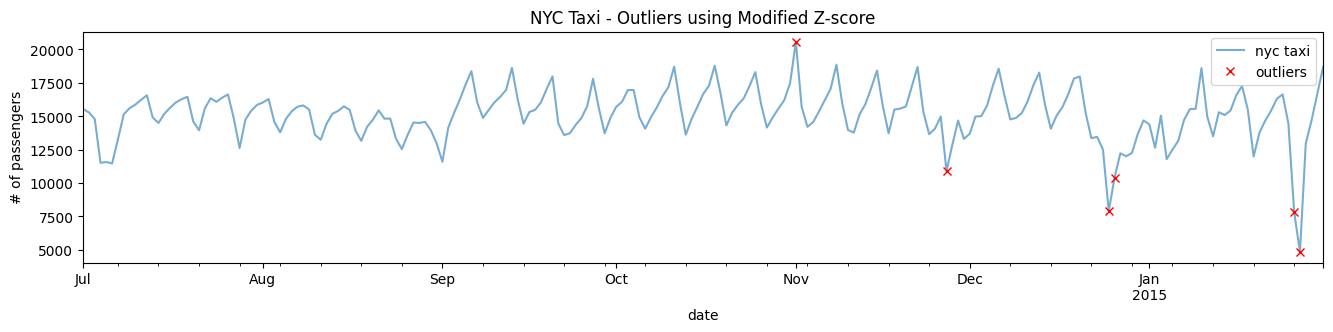

In [102]:
plot_outliers(outliers, tx, 'Outliers using Modified Z-score')

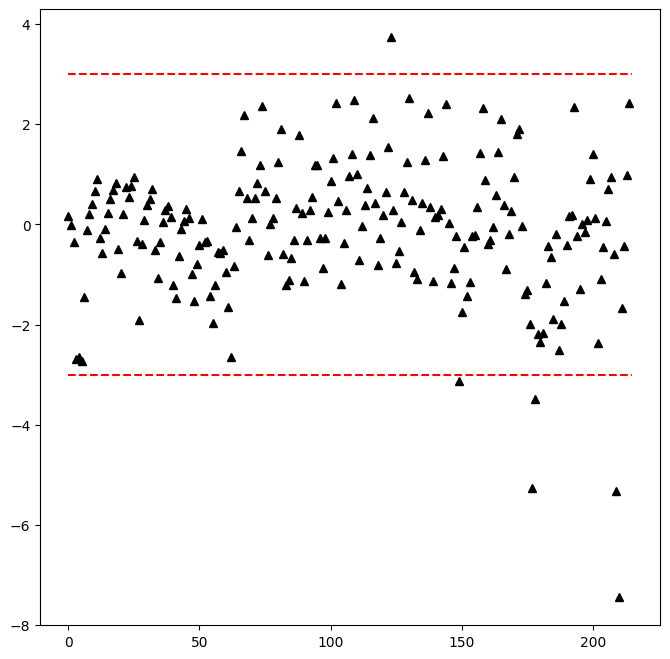

In [103]:
def plot_m_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

data = transformed['m_zscore'].values
plot_m_zscore(data, d=3)

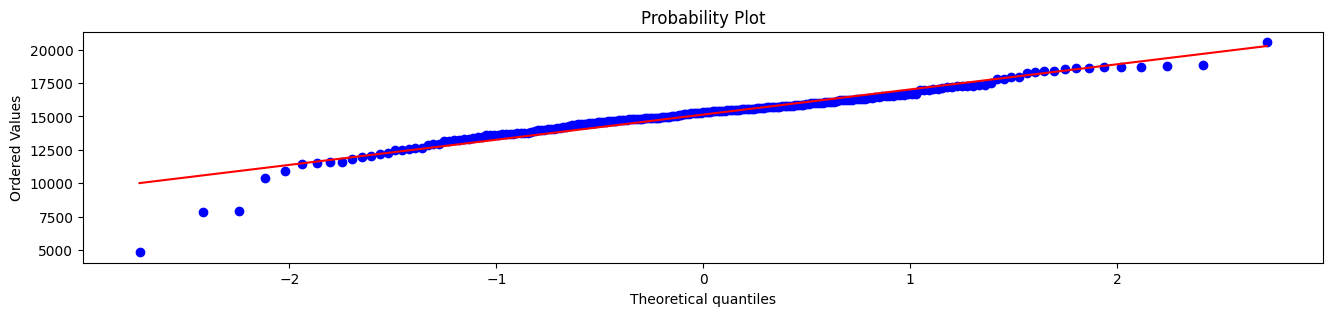

In [104]:
### Test for normality also good for outliers detection. -> Quantile-Quantile plot(QQ plot)

import scipy
import matplotlib.pyplot as plt
res = scipy.stats.probplot(tx.values.reshape(-1), plot=plt)

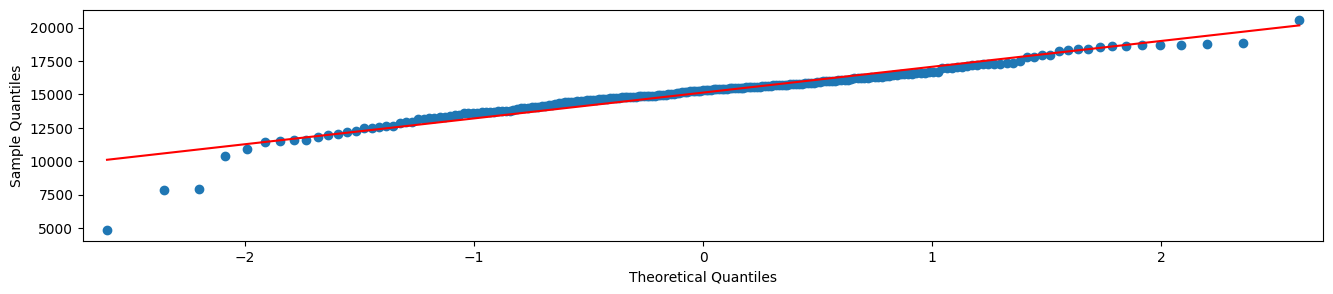

In [105]:
from statsmodels.graphics.gofplots import qqplot
qqplot(tx.values.reshape(-1), line='s');

# Exploratory Analysis and Diagnosis

In EDA, we will investigate and diagnose time series data to test for specific characteristics such as 
* Stationarity
* Effects of Trend and Seasonality
* Auto-Correlation etc

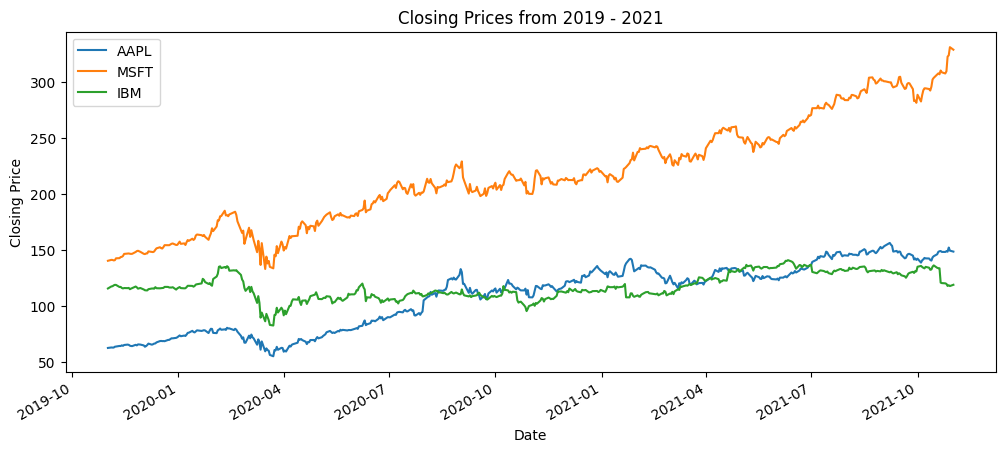

In [106]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset
import warnings

warnings.filterwarnings('ignore')

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
# plt.rc('font', size=8)                     ## 
# plt.rc('axes', titlesize=16)               ## 
# plt.rc('axes', labelsize=14)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=12)             ## 
#############################################

# pandas_df.plot(kind='') kind value can be -> line, bar, hist, box, kde, area, pie, scatter, hexbin

file = r'./CodeAndDatasets/datasets/Ch9/closing_price.csv'

closing_price = pd.read_csv(file, 
                            index_col='Date',
                            parse_dates=True)
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)
# store for future use
# airp_df.reset_index().rename(columns={'value':'passengers', 'index':'date'}).to_csv('../../datasets/Ch8/air_passenger.csv', index=False)


### Plotting Time Series Data using pandas

start_date = '2019'
end_date = '2021'
plot = closing_price.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Closing Price')
# plt.savefig('images/fig_9.1.png', bbox_inches='tight')


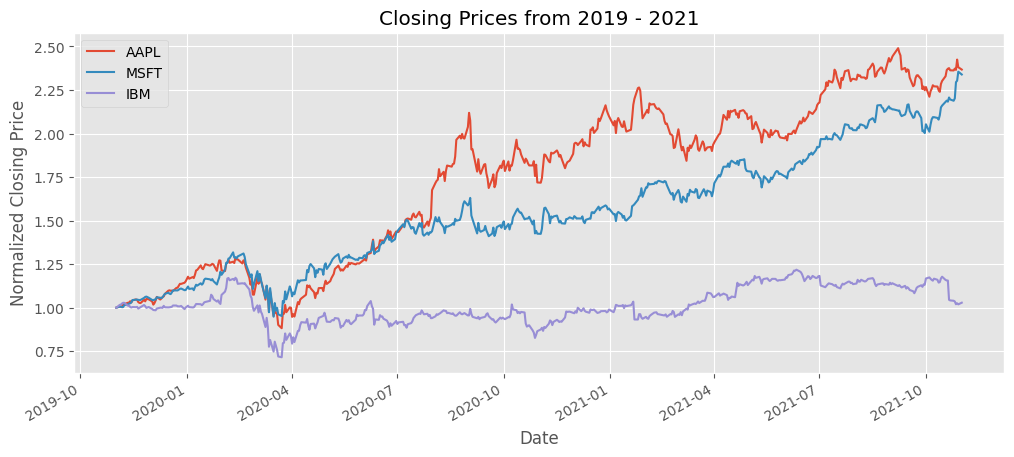

In [116]:
## to observe the comparitive fluctuations in a better way, we have to normalise the data by dividing all data points with 1st price
plt.style.use('ggplot')
closing_price_n = closing_price.div(closing_price.iloc[0])
plot = closing_price_n.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Normalized Closing Price')
#plt.savefig('images/fig_9.2.png', bbox_inches='tight')

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

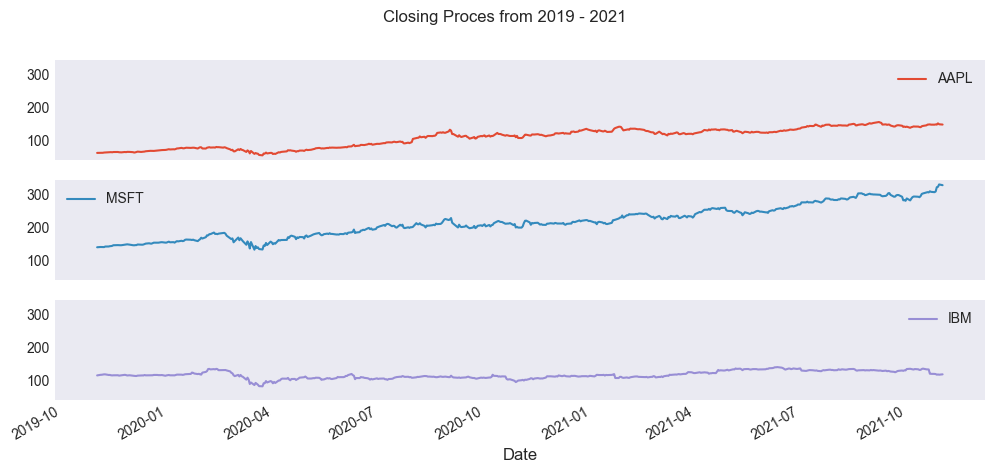

In [118]:
##  incase want to plot graphs seperately, we can use subplots option
plt.style.use('seaborn-dark')
closing_price.plot(kind='line', subplots=True, sharex=True, sharey=True, 
                    title=f'Closing Proces from {start_date} - {end_date}')
#plt.savefig('images/fig_9.5.png', bbox_inches='tight')

In [122]:
## interative visualization using hvplot
import hvplot.pandas 
import hvplot as hv

plot = closing_price_n.hvplot(
    title=f'Closing Prices from {start_date} - {end_date}')
plot

# closing_price_n.plot(backend='hvplot', 
#                      title=f'Closing Prices from {start_date} - {end_date}')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [123]:
## you can work with subplots
closing_price.hvplot(width=300, subplots=True).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [124]:
## see the data at categorical level colouring
closing_price['AAPL'].hvplot.line(by=['index.year'])

:NdOverlay   [index.year]
   :Curve   [Date]   (AAPL)

In [125]:
## hvPlot allows you to use two arithmetic operators, + and *, to configure layput of plots
# The plus sign (+) allows you to add two charts side by side

(closing_price_n['AAPL'].hvplot(width=400, height=200) + 
 closing_price_n['MSFT'].hvplot(width=400, height=200))

:Layout
   .Curve.AAPL :Curve   [Date]   (AAPL)
   .Curve.MSFT :Curve   [Date]   (MSFT)

In [127]:
#  multiply (*) will enable you to combine charts (merge one graph with another)

(closing_price_n['AAPL'].hvplot(width=600, height=350) * 
 closing_price_n['MSFT'].hvplot(width=600, height=350))

:Overlay
   .Curve.AAPL :Curve   [Date]   (AAPL)
   .Curve.MSFT :Curve   [Date]   (MSFT)

## Decomposing Time series data

3 major componenets of time series process
* Trend -> It gives long term direction of the time series and can be either upward , downward or horizontal
* Seasonlaity -> It is the Repeated patterns over time.
* Residual -> Noise left after trend and seasonlaity being extracted

seasonal_decompose, Seasonal-Trend decomposition with LOESS (STL) , and hp_filter techniques are available in the statsmodels library

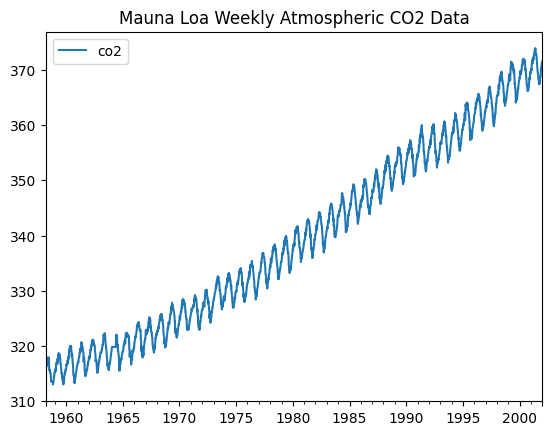

In [129]:
import statsmodels as sm
from statsmodels.datasets import elec_equip, co2
from statsmodels.tsa.seasonal import seasonal_decompose, STL

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ##
# plt.rc('font', size=8)                     ## 
# plt.rc('axes', titlesize=16)               ## 
# plt.rc('axes', labelsize=14)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=12)             ## 
#############################################

plt.style.use('default')
plpt = co2_df.plot(title=co2.TITLE)

# from plot can we understand if the data is additive or multiplicative?

# The co2_df data shows a long-term linear (upward) trend, with a repeated 
# seasonal pattern at a constant rate (seasonal variation). This indicates that the CO2 
# dataset is an additive model. 

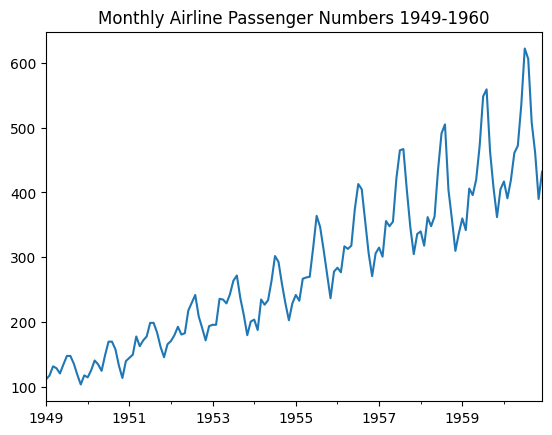

In [130]:
plot = airp_df['value'].plot(title=air_passengers['title'])

# from plot can we understand if the data is additive or multiplicative?
# The airp_df data shows a long-term linear (upward) trend and seasonality. 
# However, the seasonality fluctuations seem to be increasing as well, indicating 
# a multiplicative model.


In [132]:
### lets decompose the data using seasonal_decompose method

# from above charts, we conclude that For the CO2 data, use an additive model and a multiplicative model for the air passenger data

co2_decomposed = seasonal_decompose(co2_df, model='additive')
air_decomposed = seasonal_decompose(airp_df, model='multiplicative')

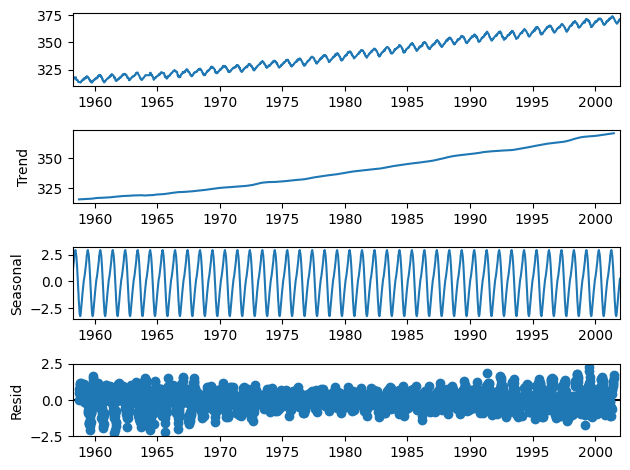

In [134]:
## Plot decomposed componenets for analysis -> additive model
co2_decomposed.plot();

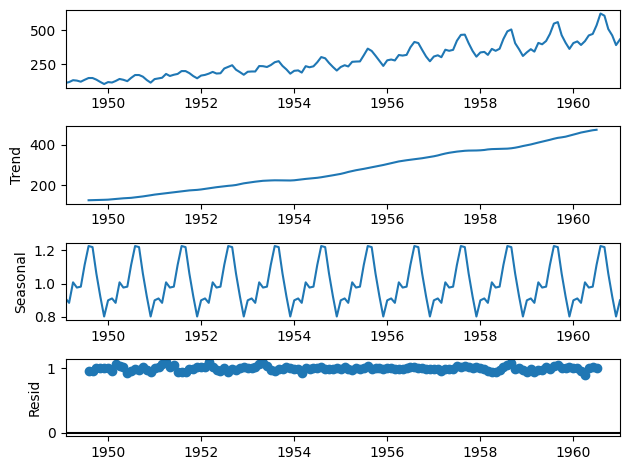

In [136]:
## Plot decomposed componenets for analysis -> multiplicative model
air_decomposed.plot();

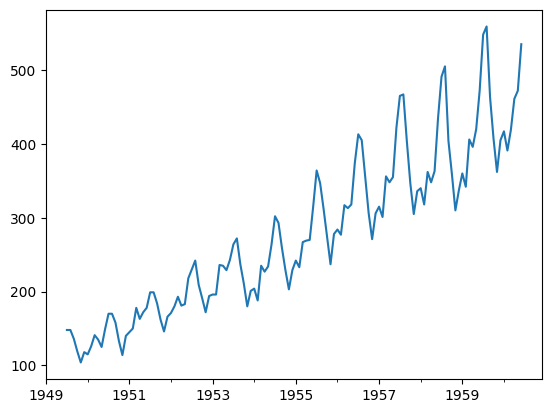

In [137]:
## reconstruct multiplicative model

plot = (air_decomposed.trend * 
     air_decomposed.seasonal * 
     air_decomposed.resid).plot()
#plt.savefig('images/fig_9.16.png', bbox_inches='tight')

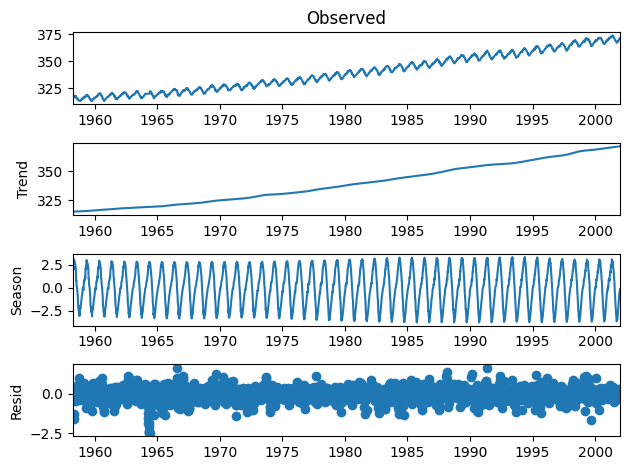

In [138]:
### Decompose data using advanced technique called 'STL'

## STL class uses 'LOESS' seasonal smoother (Locally Estimated Scatterplot Smoothing).
## STL is robust than seasonal_decompose for measuring non-libear relationships.


co2_stl = STL(
    co2_df, 
    seasonal=13, # Seasonal parameter is for seasonal smoother and can 
                 # only take ODD Integer values greater than or equal to 7.
                 # Here Seasonal = 13, because of annual seasonal effect.
    robust=True).fit() # roboust = True helps to remove the impact of outliers on 
                       # seasonal and trend components when calculated.
plot = co2_stl.plot()
#plt.savefig('images/fig_9.17.png', bbox_inches='tight')

<AxesSubplot: title={'center': 'CO2 Trend Component'}>

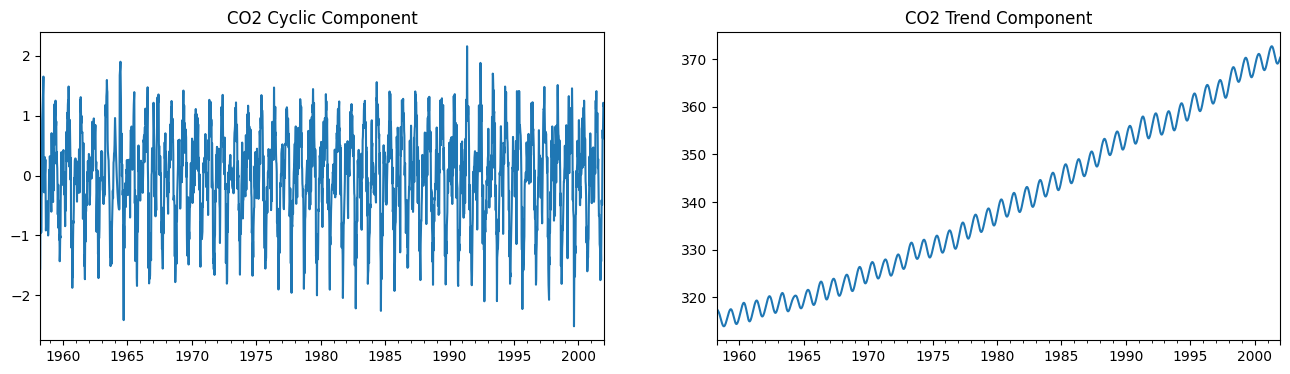

In [139]:
### Decomposition using Hodrick-prescott filter(hp filter)
## it can be used to seperate short term fluctuations(cyclic variations) from long term trends.
## Note that 2 components (trend and cyclic data) are additive
# plt.rcParams["figure.figsize"] = (20,3)

from statsmodels.tsa.filters.hp_filter import hpfilter

co2_cyclic, co2_trend = hpfilter(co2_df)

fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 Cyclic Component')
co2_trend.plot(ax=ax[1], title='CO2 Trend Component')
#fig.savefig('images/fig_9.18.png', bbox_inches='tight')

## Detecting Time series Stationarity

Several time series forecasting techniques assume **Stationarity**. A stationary time series implies that specific statistical properties do not vary over time and remain steady, making the processes easier to model and predict.  a stationary time series is defined as a time series with a **constant mean(μ), a constant variance (σ2) , and a consistent covariance (or autocorrelation)** between identical distanced periods (lags).

Generally, a time series with trend or seasonality can be considered **non-stationary**.

**Augmented Dickey-Fuller (ADF)** test and the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** test are used to test for unit roots in a univariate time series process (the presence of unit roots indicates non-stationarity).

Both ADF and KPSS are based on **linear regression** and are a type of statistical hypothesis test. 

**Null hypothesis for ADF** states that there is a unit root in the time series, and thus, it is **non-stationary**. On the other hand, **KPSS** has the opposite **null hypothesis**, which assumes the time series is **stationary**.


<AxesSubplot: ylabel='Frequency'>

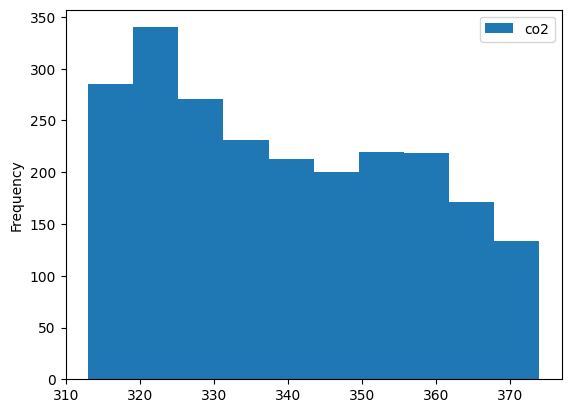

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.datasets import co2

co2_df.plot(kind='hist')

In [141]:
# statistical tests to identify stationarity of timeseries data.
def print_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)

pd.concat([print_results(adf_output, 'adf'),print_results(kpss_output, 'kpss')], axis=1)

,adf,kpss
Test Statistic,0.046051,7.649196
p-value,0.962179,0.01
Numbers of lags,27,29
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433252,0.739
Critical Value (5%),-2.862822,0.463
Critical Value (10%),-2.567452,0.347
Critical Value (2.5%),NaN,0.574


In [ ]:
## 6 (Transformations, differencing) techniques # for making time series data into stationary. 
## They are first-order differencing, second-order differencing, 
## subtracting moving average, log transformation, decomposition, 
## and Hodrick-Prescott filter.

